# Simulating random point patterns with `pointpats.random`

This notebook illustrates how to use the `pointpats.random` module to simulate
random point patterns inside a study region (the *hull*).

We will look at several families of random patterns:

1. **Homogeneous Poisson** (`random.poisson`)
2. **Normal cluster** (`random.normal`)
3. **Poisson cluster (Neyman–Scott)** (`random.cluster_poisson`)
4. **Normal cluster with random seeds** (`random.cluster_normal`)

All examples use a simple square window as the hull:

$$[0, 1] \times [0, 1].$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pointpats import random as ppr  # pointpats.random

# Make results reproducible
np.random.seed(12345)

# Define a simple square hull as a bounding box:
# [xmin, ymin, xmax, ymax]
hull = np.array([0.0, 0.0, 1.0, 1.0])

hull

array([0., 0., 1., 1.])

## Helper function for plotting point patterns

We'll use a small helper to visualize realizations of the random point processes.

In [2]:
def plot_pattern(points, hull, ax=None, title=None):
    """Plot a 2D point pattern inside a rectangular hull.

    Parameters
    ----------
    points : array-like, shape (n_points, 2)
        Coordinates of the points.
    hull : array-like, shape (4,)
        Bounding box [xmin, ymin, xmax, ymax].
    ax : matplotlib.axes.Axes, optional
        Axis to plot on.
    title : str, optional
        Title for the plot.
    """
    points = np.asarray(points)

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    xmin, ymin, xmax, ymax = hull
    ax.scatter(points[:, 0], points[:, 1], s=10, alpha=0.7)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if title:
        ax.set_title(title)

    return ax

## 1. Homogeneous Poisson process (`random.poisson`)

The **homogeneous Poisson point process** is the canonical model of
*complete spatial randomness* (CSR):

- Each point is independently and uniformly distributed in the hull.
- The expected number of points is controlled by the **intensity**
  (points per unit area).

A typical interface (check the installed `pointpats` version for details) allows usage patterns like:

- `poisson(hull, size=n)` — simulate `n` points once.
- `poisson(hull, intensity=lambda_, size=r)` — draw `r` *replications* from a Poisson
  process with intensity `lambda_` points per unit area.


In [3]:
# A single realization with exactly 100 points
points_poisson_fixed = ppr.poisson(hull, size=100)

points_poisson_fixed.shape

(100, 2)

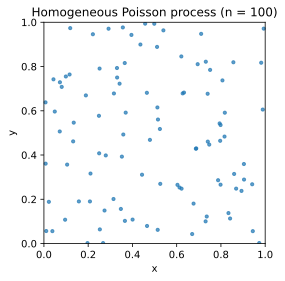

In [4]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_pattern(points_poisson_fixed, hull, ax=ax,
             title="Homogeneous Poisson process (n = 100)")
plt.show()

In [5]:
# Simulate 4 replications with intensity λ = 200 points per unit area
lambda_ = 200  # expected number of points in unit square
n_replications = 4

points_poisson_intensity = ppr.poisson(hull, intensity=lambda_, size=n_replications)

points_poisson_intensity.shape

(4, 200, 2)

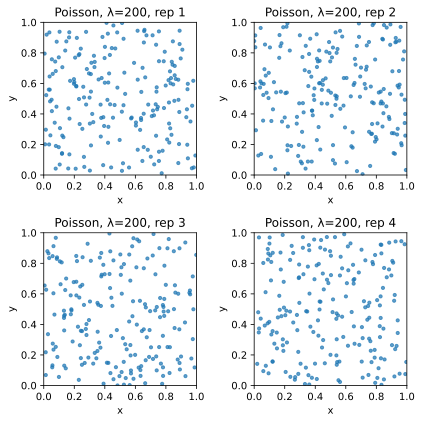

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for i, ax in enumerate(axes.ravel()):
    plot_pattern(points_poisson_intensity[i], hull, ax=ax,
                 title=f"Poisson, λ={lambda_}, rep {i+1}")

plt.tight_layout()
plt.show()

## 2. Normal cluster (`random.normal`)

`random.normal` simulates points from a **bivariate normal distribution**
truncated to the hull.

A typical interface looks like:

```python
ppr.normal(hull, center=None, cov=None, size=None)
```

Key arguments:

- `center`: 2D location of the cluster center. If `None`, often the centroid of the hull.
- `cov`: covariance structure (scalar = iid variance, or 2×2 matrix).
- `size`: number of points (and optionally replications).

We'll start with a single tight cluster in the center of the window.

In [7]:
# 200 points in a single bivariate normal cluster
points_normal = ppr.normal(hull, size=200)

points_normal.shape

(200, 2)

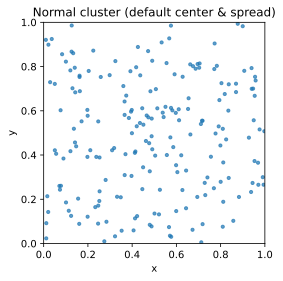

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_pattern(points_normal, hull, ax=ax,
             title="Normal cluster (default center & spread)")
plt.show()

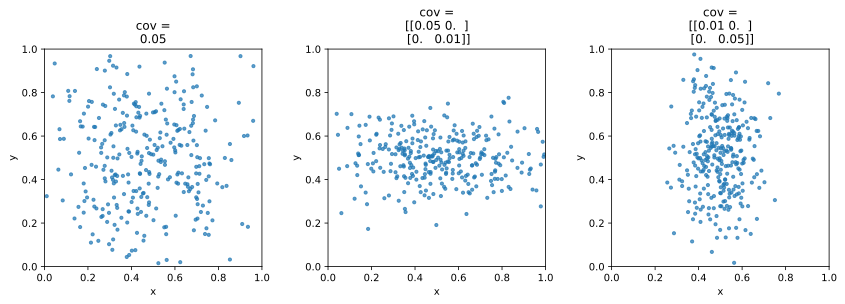

In [9]:
# Three different covariance structures
covariances = [
    0.05,  # scalar: isotropic variance
    np.array([[0.05, 0.0], [0.0, 0.01]]),  # elongated along x
    np.array([[0.01, 0.0], [0.0, 0.05]]),  # elongated along y
]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for cov, ax in zip(covariances, axes):
    pts = ppr.normal(hull, size=300, cov=cov)
    plot_pattern(pts, hull, ax=ax, title=f"cov =\n{cov}")

plt.tight_layout()
plt.show()

## 3. Poisson cluster process (`random.cluster_poisson`)

`cluster_poisson` implements a simple **Neyman–Scott**–type cluster process:

1. "Seed" points are drawn from a Poisson process.
2. Around each seed, a small cloud of points is placed within a radius.

A typical use looks like:

```python
ppr.cluster_poisson(
    hull,
    intensity=None,
    size=None,
    n_seeds=2,
    cluster_radius=None,
)
```

Key arguments:

- `n_seeds`: number of cluster centers.
- `cluster_radius`: radius of each cluster. If `None`, it may default to a value
  based on distances between seeds.
- `size`: controls how many points you simulate in total and how many replications.

Here we simulate 300 points organized into a few clusters.

In [10]:
n_points = 300
n_replications = 1
n_seeds = 4

points_cluster_poisson = ppr.cluster_poisson(
    hull,
    size=(n_points, n_replications),
    n_seeds=n_seeds,
    # cluster_radius can be None (default) or a scalar / array
)

points_cluster_poisson.shape

(300, 2)

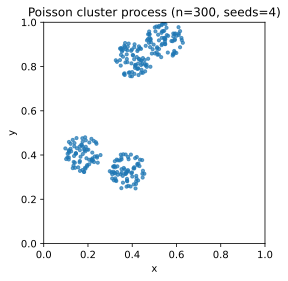

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_pattern(points_cluster_poisson, hull, ax=ax,
             title=f"Poisson cluster process (n={n_points}, seeds={n_seeds})")
plt.show()

## 4. Normal clusters with random seeds (`random.cluster_normal`)

`cluster_normal` builds clusters whose centers are themselves drawn from a
Poisson process, but the points within clusters are drawn from a **normal**
distribution around each seed:

```python
ppr.cluster_normal(hull, cov=None, size=None, n_seeds=2)
```

- `cov` controls the within-cluster spread.
- `n_seeds` controls how many clusters you get.
- `size` controls total number of points and replications.


In [12]:
n_points = 300
n_replications = 1
n_seeds = 5

points_cluster_normal = ppr.cluster_normal(
    hull,
    size=(n_points, n_replications),
    n_seeds=n_seeds,
    # cov=None uses a default based on distances between seeds
)

points_cluster_normal.shape

(300, 2)

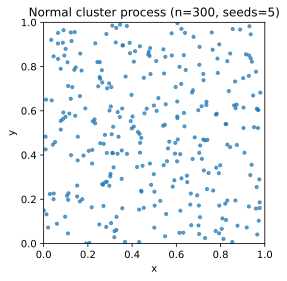

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
plot_pattern(points_cluster_normal, hull, ax=ax,
             title=f"Normal cluster process (n={n_points}, seeds={n_seeds})")
plt.show()

## Recap

In this notebook we have:

- Used `pointpats.random.poisson` to simulate homogeneous Poisson
  point patterns under complete spatial randomness.
- Used `pointpats.random.normal` to generate truncated bivariate normal clusters.
- Used `pointpats.random.cluster_poisson` for Poisson cluster processes
  (Neyman–Scott–like).
- Used `pointpats.random.cluster_normal` for clustered patterns with
  normally distributed clusters.

These simulated patterns are useful as:

- **Null models** for hypothesis testing (e.g., against observed patterns).
- **Toy data** for teaching, examples, and algorithm development.

You can adapt the hull, intensities, and covariance structures to match
your own study regions and applications.